### 1. Problem statement
 - We are given Google stock price from 01/2012 to 12/2017. 
 - The task is to predict the trend of the stock price for 01-06 2018. 

### 2. Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### 3. Data processing

#### 3.0 import the data

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [8]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [9]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values

In [10]:
training_set.shape

(1509, 1)

#### 3.1 Feature scaling

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

#### 3.2 Data structure creation

taking the reference of past 60 days of data to predict the future stock price.  
It is observed that taking 60 days of past data gives us best results.  
In this data set 60 days of data means 3 months of data.  
Every month as 20 days of Stock price.   
X train will have data of 60 days prior to our date and y train will have data of one day after our date

In [12]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train.shape

(1449, 60)

In [15]:
y_train.shape

(1449,)

#### 3.3 Data reshaping

In [16]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

1. Number of stock prices - 1449  
2. Number of time steps - 60  
3. Number of Indicator - 1  

In [17]:
X_train.shape

(1449, 60, 1)

### 4. Create & Fit Model

#### 4.1 Create model

In [18]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [19]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### 4.2 Model fit

In [20]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
46/46 [==============================] - 8s 167ms/step - loss: 0.0173 0s - loss: 0.0
Epoch 2/100
46/46 [==============================] - 8s 176ms/step - loss: 0.0042
Epoch 3/100
46/46 [==============================] - 10s 216ms/step - loss: 0.0038
Epoch 4/100
46/46 [==============================] - 9s 192ms/step - loss: 0.0033
Epoch 5/100
46/46 [==============================] - 10s 211ms/step - loss: 0.0031
Epoch 6/100
46/46 [==============================] - 8s 169ms/step - loss: 0.0030
Epoch 7/100
46/46 [==============================] - 10s 222ms/step - loss: 0.0031
Epoch 8/100
46/46 [==============================] - 11s 229ms/step - loss: 0.00370s - loss: 0.00
Epoch 9/100
46/46 [==============================] - 10s 218ms/step - loss: 0.0025
Epoch 10/100
46/46 [==============================] - 8s 171ms/step - loss: 0.0030
Epoch 11/100
46/46 [==============================] - 9s 198ms/step - loss: 0.0027
Epoch 12/100
46/46 [==============================] - 9s 195m

46/46 [==============================] - 5s 111ms/step - loss: 9.3553e-04
Epoch 99/100
46/46 [==============================] - 6s 123ms/step - loss: 9.6576e-04
Epoch 100/100
46/46 [==============================] - 6s 123ms/step - loss: 8.7687e-04


#### 4.3 Model evaluation

#### 4.3.1 Read and convert

In [22]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [23]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [25]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(125, 1)

#### 4.3.2 Concat and convert

In [26]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#### 4.3.3 Reshape and scale

In [27]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [33]:
len(inputs)

185

#### 4.3.4 Create test data strucutre

In [34]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [35]:
X_test.shape

(125, 60, 1)

#### 4.3.5 Model prediction

In [36]:
predicted_stock_price = regressor.predict(X_test)

In [37]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### 4.3.6 Result visualization

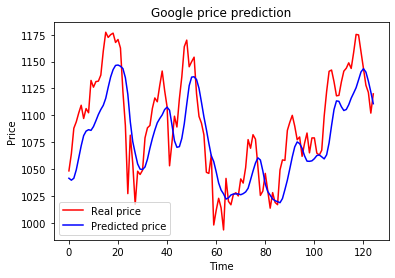

In [38]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()